In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import pydrake
import pyro
import torch
print(pyro.__path__)

['/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/pyro']


tensor([-0.3790,  0.9402])
['maf$$$arn.layers.0.weight', 'maf$$$arn.layers.4.bias', 'maf$$$arn.layers.2.weight', 'maf$$$arn.layers.0.bias', 'maf$$$arn.layers.2.bias', 'maf$$$arn.layers.4.weight']


(-4, 4)

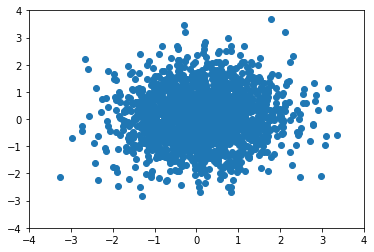

In [2]:
import pyro.distributions as dist
from pyro.nn import AutoRegressiveNN
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
maf = dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [10, 10]))
maf_module = pyro.module("maf", maf)
maf_dist = dist.TransformedDistribution(base_dist, [maf])
print(maf_dist.sample())
ps = pyro.get_param_store()
print(ps.get_all_param_names())
samples = maf_dist.sample(sample_shape=[1000, 2])
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlim(-4, 4)
plt.ylim(-4, 4)

(-4, 4)

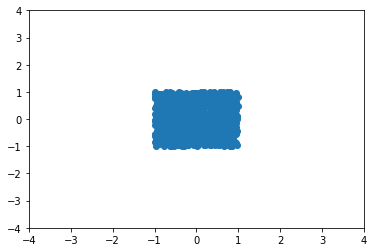

In [3]:
N = 1000

#Circle
#theta = np.random.random(N)*np.pi*2.
#radius = np.random.randn(N)*0.1 + 1.
#X = np.cos(theta)*radius
#Y = np.sin(theta)*radius
#Moon
#X = np.random.randn(N)*4
#Y = np.random.randn(N)*1 + (.25)*X**2
# Box
X = np.random.uniform(-1., 1., [N, 1])
Y = np.random.uniform(-1., 1., [N, 1])
prepend = np.random.randn(N, 2)
plt.scatter(X, Y)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [4]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.contrib.autoguide import AutoDelta
from pyro import poutine

losses = []

torch.set_default_tensor_type('torch.cuda.FloatTensor')

data = torch.tensor(np.hstack([prepend, X, Y]), dtype=torch.float).cuda()

size = data.shape[-1]
base_dist = dist.Normal(torch.zeros(size), torch.ones(size)).to_event(1)
layer_sizes = [20, 20]
p_dropout = 0.0
flows = [
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(size, layer_sizes, dropout_p=p_dropout)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(size, layer_sizes, dropout_p=p_dropout)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(size, layer_sizes, dropout_p=p_dropout)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(size, layer_sizes, dropout_p=p_dropout)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(size, layer_sizes, dropout_p=p_dropout))
    #dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5, 5])),
    #dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5, 5])),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
]

tf_dist = dist.TransformedDistribution(base_dist, flows)
print(tf_dist.event_shape, tf_dist.batch_shape)
pyro.clear_param_store()

prior_samples = tf_dist.sample(sample_shape=(1000, size)).cpu().detach().numpy()

def model(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)
    with pyro.plate("data_plate", data.shape[0]):
        pyro.sample("data", tf_dist, obs=data)

def guide(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)

#guide = AutoDelta(poutine.block(model, hide=["obs"]))
print(tf_dist.log_prob(data).shape)

# setup the inference algorithm
optimizer = Adam({"lr": 0.001, "betas": (0.90, 0.999), "weight_decay": 1E-3})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(5000):
    loss = svi.step(data) / data.shape[0]
    losses.append(loss)
    if (step % 100 == 0):
        print(loss)

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 GeForce GTX 680 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


torch.Size([4]) torch.Size([])
torch.Size([1000])
5.43520703125
4.54594433594
4.52488964844
4.49644042969
4.42502294922
4.28292773437
4.21070507812
4.161640625
4.18189746094
4.14368847656
4.10258007813
4.07340576172
4.05603808594
5.11845751953
4.49581542969
4.388953125
4.30968017578
4.27240429688
4.24074072266
4.2212578125
4.20726660156
4.19397363281
4.18238427734
4.17294873047
4.17448828125
4.15584765625
4.14720898438
4.13887451172
4.12896972656
4.12180664062
4.1112890625


KeyboardInterrupt: 

In [25]:
# setup the inference algorithm
optimizer = Adam({"lr": 0.0001, "betas": (0.90, 0.999)})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
for step in range(5000):
    loss = svi.step(data)
    losses.append(loss)
    if (step % 100 == 0):
        print(loss)

1517.83691406
7447.42236328
3193.01416016
3549.17724609
3698.66577148
5.56254992794e+12
2.11977293005e+13


KeyboardInterrupt: 

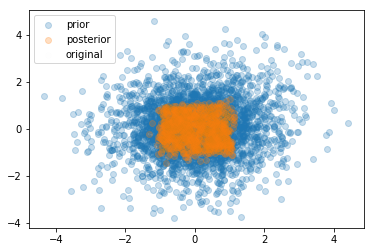

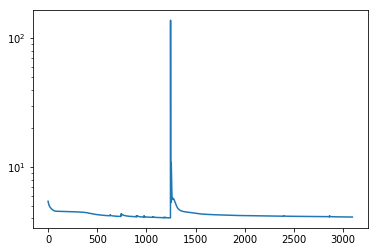

In [5]:
for flow in flows:
    flow.arn.set_dropout_p(0.0)

posterior_samples = tf_dist.expand([1000]).sample().cpu().detach().numpy()
plt.scatter(prior_samples[:, -2], prior_samples[:, -1], label="prior", alpha=0.25)
plt.scatter(posterior_samples[:, -2], posterior_samples[:, -1], label="posterior", alpha=0.25)
plt.scatter(X, Y, label="original", alpha=0.005)
plt.legend()
plt.figure()
plt.semilogy(losses)

-3883240400.0 -2.6166167


Text(0.5,1,'Example data (red dots) and learned 2D distribution (blue low, yellow high)')

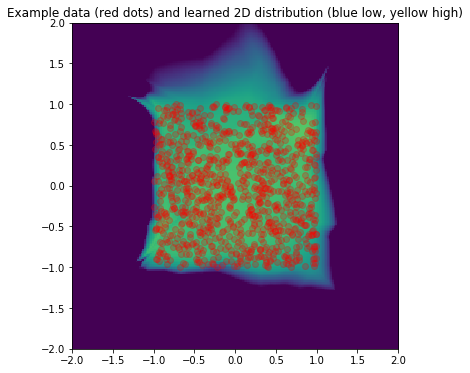

In [6]:
# Draw PDF
x_bounds = [-2, 2]
y_bounds = [-2, 2]
n_pts = [200, 200]
sufficiently_sized_zeros = np.zeros(n_pts).flatten()
Xi, Yi = np.meshgrid(np.linspace(x_bounds[0], x_bounds[1], n_pts[0]),
                   np.linspace(y_bounds[0], y_bounds[1], n_pts[1]),
                   indexing="ij")

logprobs = tf_dist.log_prob(torch.tensor(
    np.vstack([sufficiently_sized_zeros, sufficiently_sized_zeros, Xi.flatten(), Yi.flatten()]).T, dtype=torch.float))
logprobs = logprobs.cpu().detach().numpy().reshape(n_pts).T
    
print(logprobs.min(), logprobs.max())
plt.figure().set_size_inches(6, 6)
plt.scatter(X, Y, label="original", alpha=0.25, c='r')
plt.imshow(logprobs, extent=x_bounds+y_bounds, vmin=-10, vmax=0)
plt.title("Example data (red dots) and learned 2D distribution (blue low, yellow high)")

In [93]:
trace = poutine.trace(model).get_trace(data)
trace.compute_log_prob()
print(trace.format_shapes())

               Trace Shapes:          
                Param Sites:          
flow_0$$$arn.layers.0.weight   10  2  
  flow_0$$$arn.layers.0.bias      10  
flow_0$$$arn.layers.1.weight   10 10  
  flow_0$$$arn.layers.1.bias      10  
flow_0$$$arn.layers.2.weight    2 10  
  flow_0$$$arn.layers.2.bias       2  
flow_1$$$arn.layers.0.weight   10  2  
  flow_1$$$arn.layers.0.bias      10  
flow_1$$$arn.layers.1.weight   10 10  
  flow_1$$$arn.layers.1.bias      10  
flow_1$$$arn.layers.2.weight    2 10  
  flow_1$$$arn.layers.2.bias       2  
               Sample Sites:          
             data_plate dist       |  
                       value 1000  |  
                    log_prob       |  
                   data dist 1000  | 1
                       value 1000  | 1
                    log_prob 1000  |  


In [10]:
# Now try conditional flows

from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.contrib.autoguide import AutoDelta
from pyro import poutine
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
from pyro.nn import AutoRegressiveNN

#torch.set_default_tensor_type('torch.cuda.FloatTensor')

losses = []

N = 10000

Y = np.random.randn(N)*4
X = np.random.randn(N)*1 + (.25)*Y**2
data = torch.tensor(np.stack([X, Y]).T, dtype=torch.float).cuda()

optimizer = Adam({"lr": 0.0001, "betas": (0.90, 0.999)})

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
flows = [
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1))
]

tf_dist = dist.TransformedDistribution(base_dist, flows)
print(tf_dist.event_shape, tf_dist.batch_shape)
pyro.clear_param_store()

N_samples = X.shape[0]
sample_zs = torch.tensor(X, dtype=torch.float).unsqueeze(-1) #torch.randn((N_samples, 1))*4
for flow in flows:
    flow.set_z(sample_zs)
prior_samples = torch.stack([sample_zs, tf_dist.sample(sample_shape=(N_samples,))])[:, :, 0].cpu().detach().numpy().T

def model(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)
    with pyro.plate("data_plate", data.shape[0]):
        for flow in flows:
            flow.set_z(data[:, 0].unsqueeze(-1))
        pyro.sample("data", tf_dist, obs=data[:, 1].unsqueeze(-1))

def guide(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)

#guide = AutoDelta(poutine.block(model, hide=["obs"]))
for flow in flows:
    flow.set_z(data[:, 0].unsqueeze(-1))
print(tf_dist.log_prob(data[:, 1].unsqueeze(-1)).shape)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(5000):
    loss = svi.step(data)
    losses.append(loss)
    if (step % 100 == 0):
        print(loss)

torch.Size([1]) torch.Size([])
torch.Size([10000])
375560288.0
24520.7851562
24243.1777344
24188.4609375
24174.1367188
24168.890625
24165.6640625
24163.3007812
24161.6796875
24160.2304688
24158.6875


KeyboardInterrupt: 

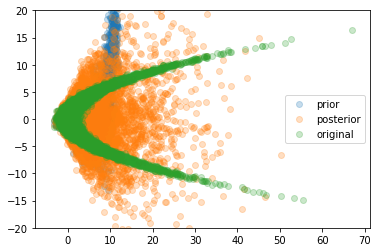

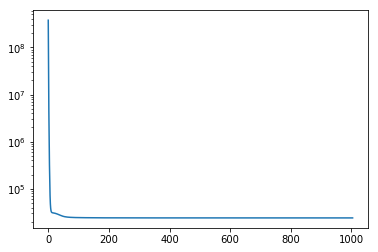

In [11]:
for flow in flows:
    flow.set_z(sample_zs)
posterior_samples = torch.stack([sample_zs, tf_dist.sample(sample_shape=(N_samples,))])[:, :, 0].detach().cpu().numpy().T
plt.scatter(prior_samples[:, 0], prior_samples[:, 1], label="prior", alpha=0.25)
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.25)
plt.scatter(X, Y, label="original", alpha=0.25)
plt.ylim([-20, 20])
plt.legend()
plt.figure()
plt.semilogy(losses)

-32938954.0 3.2566795


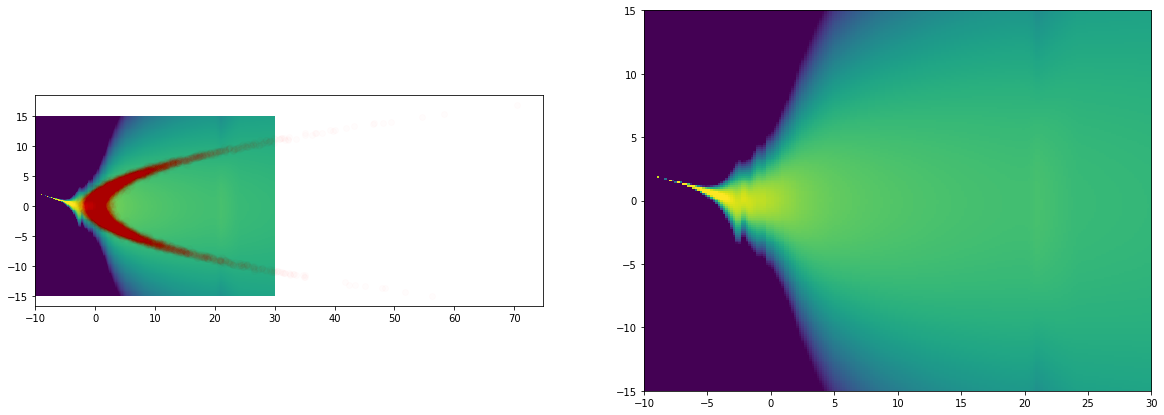

In [9]:
# Draw PDF
x_bounds = [-10, 30]
y_bounds = [-15, 15]
n_pts = [200, 200]

xpts = np.linspace(x_bounds[0], x_bounds[1], n_pts[0])
ypts = np.linspace(y_bounds[0], y_bounds[1], n_pts[1])
Xi, Yi = np.meshgrid(xpts, ypts, indexing="ij")


for flow in flows:
    flow.set_z(torch.tensor(Xi.flatten(), dtype=torch.float).unsqueeze(-1))
logprobs = tf_dist.log_prob(torch.tensor(Yi.flatten(), dtype=torch.float).unsqueeze(-1))
logprobs = logprobs.detach().detach().cpu().numpy().reshape(n_pts).T


print(logprobs.min(), logprobs.max())
plt.figure().set_size_inches(20, 20)
plt.subplot(1, 2, 1)
plt.imshow(logprobs, extent=x_bounds+y_bounds, vmin=-10, vmax=0)
plt.scatter(X, Y, label="original", alpha=0.01, c='r')
plt.subplot(1, 2, 2)
plt.imshow(logprobs, extent=x_bounds+y_bounds, vmin=-10, vmax=0)
#plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.1)

In [25]:
N = 10000

pyro.clear_param_store()

Y = np.random.randn(N)*4
X = np.random.randn(N)*1 + (.25)*Y**2
data = torch.tensor(np.stack([X, Y]).T, dtype=torch.float).cuda()

torch.manual_seed(time.time())
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
flows = [
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [5, 5], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [5, 5], observed_dim=1))
]

tf_dist = dist.TransformedDistribution(base_dist, flows)
for flow_i, flow in enumerate(flows):
    pyro.module("flow_{}".format(flow_i), flow)
    
torch.manual_seed(0)
for flow in flows:
    flow.set_z(torch.tensor(1, dtype=torch.float).unsqueeze(-1))
    
print("Log prob of 1.23: ", tf_dist.log_prob(torch.tensor([1.23])))

print(pyro.get_param_store().get_all_param_names())

pyro.get_param_store().save("test.pyro")

Log prob of 1.23:  tensor(-2.0815, grad_fn=<AddBackward0>)
['flow_0$$$arn.layers.0.bias', 'flow_1$$$arn.layers.2.bias', 'flow_1$$$arn.layers.4.weight', 'flow_0$$$arn.layers.4.bias', 'flow_0$$$arn.layers.2.weight', 'flow_1$$$arn.layers.0.bias', 'flow_1$$$arn.layers.4.bias', 'flow_0$$$arn.layers.0.weight', 'flow_0$$$arn.layers.2.bias', 'flow_0$$$arn.layers.4.weight', 'flow_1$$$arn.layers.0.weight', 'flow_1$$$arn.layers.2.weight']


In [26]:
N = 10000

pyro.clear_param_store()

Y = np.random.randn(N)*4
X = np.random.randn(N)*1 + (.25)*Y**2
data = torch.tensor(np.stack([X, Y]).T, dtype=torch.float).cuda()

torch.manual_seed(time.time()*1000)
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
flows = [
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [5, 5], observed_dim=1)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [5, 5], observed_dim=1)),
]

tf_dist = dist.TransformedDistribution(base_dist, flows)

print(pyro.get_param_store().get_all_param_names())

pyro.get_param_store().load("test.pyro")
print(pyro.get_param_store().get_all_param_names())

for flow_i, flow in enumerate(flows):
    pyro.module("flow_{}".format(flow_i), flow, update_module_params=True)

torch.manual_seed(0)
for flow in flows:
    flow.set_z(torch.tensor(1, dtype=torch.float).unsqueeze(-1))
print("Log prob of 1.23: ", tf_dist.log_prob(torch.tensor([1.23])))

[]
['flow_0$$$arn.layers.0.bias', 'flow_1$$$arn.layers.2.bias', 'flow_1$$$arn.layers.4.weight', 'flow_0$$$arn.layers.4.bias', 'flow_0$$$arn.layers.2.weight', 'flow_1$$$arn.layers.0.bias', 'flow_1$$$arn.layers.4.bias', 'flow_0$$$arn.layers.0.weight', 'flow_0$$$arn.layers.2.bias', 'flow_0$$$arn.layers.4.weight', 'flow_1$$$arn.layers.0.weight', 'flow_1$$$arn.layers.2.weight']
Log prob of 1.23:  tensor(-2.0815, grad_fn=<AddBackward0>)
